In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import Dataset, random_split
from tqdm.notebook import tqdm #Pretty progress bar
import matplotlib.pyplot as plt

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616])
])

dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

train_data, test_data = random_split(dataset, [int(len(dataset) * 0.8), int(len(dataset) * 0.2)])

val_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders
trainloader = DataLoader(train_data, batch_size=64, shuffle=True)
testloader = DataLoader(test_data, batch_size=64, shuffle=False)
valloader = DataLoader(val_data, batch_size=64, shuffle=False)

100%|████████████████████████████████████████████████████████████████████████| 170M/170M [02:40<00:00, 1.07MB/s]


In [6]:
#View my datasets
print("Train data:", len(train_data))
print("Test data:", len(test_data))
print("Val data:", len(val_data))
print("Img dimensions:", train_data[0][0].shape)

Train data: 40000
Test data: 10000
Val data: 10000
Img dimensions: torch.Size([3, 32, 32])


In [9]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        # Convolutional layers
        self.lay1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.lay2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)

        # Activation and dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
    def forward(self, x):
        # Convolutional layers
        out = self.relu(self.lay1(x))
        out = self.relu(self.lay2(out))
        out = self.maxpool1(out)

        # Flatten the output
        out = out.view(out.size(0), -1)  # Reshape

        # Fully connected layers
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)

        return out

In [10]:
model = CNN(num_classes=10)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00075)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

CNN(
  (lay1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lay2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [12]:
#Train the model

#Epochs is the number of times the model goes through the dataset
num_epochs = 5
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in tqdm(trainloader, desc='Training loop'):
        #Move to device
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass: Compute predictions
        optimizer.zero_grad()
        predictions = model(images)
        
        # Calculate loss
        loss = criterion(predictions, labels)
        
        # Backward pass: Update weights
        loss.backward()

        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    
    train_loss = running_loss / len(trainloader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(valloader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(valloader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")


Training loop:   0%|          | 0/625 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 1.5303471141815186, Validation loss: 1.1977135595321655


Training loop:   0%|          | 0/625 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 1.1753871654510497, Validation loss: 1.0097667607307435


Training loop:   0%|          | 0/625 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 1.0337047679901123, Validation loss: 0.9679119960784912


Training loop:   0%|          | 0/625 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 0.9317095430374146, Validation loss: 0.9150877553939819


Training loop:   0%|          | 0/625 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 0.8477263680934906, Validation loss: 0.8977273365974426


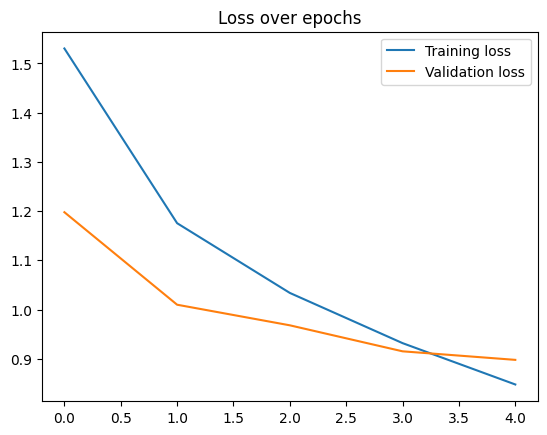

In [13]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

### Padding

Padding involves adding extra pixels around the edges of the input in convolutional layers to control the output size. 

- **Purpose:** Prevents reduction in feature map size and helps retain edge information.
- **Higher Padding:** Keeps output size closer to input, preserving edge details but may increase computation.
- **Lower Padding:** Reduces output size and can speed up computations, but may lose edge details.

---

### ReLU (Rectified Linear Unit)

ReLU is an activation function that outputs the input if it's positive; otherwise, it outputs zero (`ReLU(x) = max(0, x)`).

- **Purpose:** Introduces non-linearity and accelerates training by avoiding the vanishing gradient problem.
- **Higher Values:** Faster convergence but can lead to exploding gradients if inputs are too large.
- **Lower Values (near zero):** Can cause "dead neurons" if inputs are negative, reducing model capacity.

---

### Dropout

Dropout is a regularization technique where randomly selected neurons are ignored (dropped out) during training.

- **Purpose:** Prevents overfitting by reducing co-dependence between neurons.
- **Higher Dropout Rate:** Increases regularization, reducing overfitting but can slow down learning.
- **Lower Dropout Rate:** Less regularization, which may lead to overfitting but allows the model to learn faster.
